In [125]:
import os

input_path = "./dataset_EI4/train/images"
target_path = "./dataset_EI4/train/masks"

In [126]:
Img_size=(256,256)
Nbr_classes=10
batch_size= 32 #J'en sais rien

In [127]:
input_img_paths = sorted([os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".tif")])
target_img_paths = sorted([os.path.join(target_path, fname) for fname in os.listdir(target_path) if fname.endswith(".tif")])

In [128]:
print("Number of samples:", len(input_img_paths))
print("Number of labels:", len(target_img_paths))

Number of samples: 18491
Number of labels: 18491


In [129]:
for i, j in zip(input_img_paths[:10], target_img_paths[:10]):
  print(i,"|", j)

./dataset_EI4/train/images\1.tif | ./dataset_EI4/train/masks\1.tif
./dataset_EI4/train/images\10.tif | ./dataset_EI4/train/masks\10.tif
./dataset_EI4/train/images\100.tif | ./dataset_EI4/train/masks\100.tif
./dataset_EI4/train/images\1000.tif | ./dataset_EI4/train/masks\1000.tif
./dataset_EI4/train/images\10000.tif | ./dataset_EI4/train/masks\10000.tif
./dataset_EI4/train/images\10001.tif | ./dataset_EI4/train/masks\10001.tif
./dataset_EI4/train/images\10002.tif | ./dataset_EI4/train/masks\10002.tif
./dataset_EI4/train/images\10003.tif | ./dataset_EI4/train/masks\10003.tif
./dataset_EI4/train/images\10004.tif | ./dataset_EI4/train/masks\10004.tif
./dataset_EI4/train/images\10005.tif | ./dataset_EI4/train/masks\10005.tif


## What does one input image and corresponding segmentation mask look like?

In [130]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
#from osgeo import gdal 
import numpy as np 
import matplotlib.pyplot as plt 
from io import BytesIO

In [131]:
from tifffile import TiffFile
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt

def disp_tiff(filename):
  with TiffFile(filename) as tif:
    landcover = tif.asarray()
  cmap = colors.ListedColormap(['k', #nodata, absent from the dataset
                                'magenta', #clouds, very few in the dataset
                                'red', #artifical
                                'khaki', #cultivated
                                'green', #broadleaf forest
                                'darkgreen', #coniferous forest
                                'lightgreen', #herbaceous vegetation
                                'grey', #natural soil
                                'white', #permanent snow
                                'blue' ]) #water
  bounds=np.arange(10)
  norm= colors.BoundaryNorm(bounds, cmap.N)
  plt.imshow(landcover, cmap = cmap, norm=norm)
  
def load_img_tiff(filename):
    with TiffFile(filename) as tif:
      landcover = tif.asarray()
      cmap = colors.ListedColormap(['k', #nodata, absent from the dataset
                                  'magenta', #clouds, very few in the dataset
                                  'red', #artifical
                                  'khaki', #cultivated
                                  'green', #broadleaf forest
                                  'darkgreen', #coniferous forest
                                  'lightgreen', #herbaceous vegetation
                                  'grey', #natural soil
                                  'white', #permanent snow
                                  'blue' ]) #water
    bounds=np.arange(10)
    norm= colors.BoundaryNorm(bounds, cmap.N)
    Img=[landcover, cmap, bounds, norm]
    return Img[0]
  

In [132]:
filename_img=input_img_paths[4]
load_img_tiff(filename_img)

array([[[ 213,  331,  194, 2618],
        [ 192,  320,  136, 2538],
        [ 192,  320,  136, 2538],
        ...,
        [  83,  176,   74, 2037],
        [ 104,  168,   75, 1990],
        [ 104,  168,   75, 1990]],

       [[ 213,  331,  194, 2618],
        [ 234,  352,  184, 2559],
        [ 234,  352,  184, 2559],
        ...,
        [ 181,  266,  198, 1960],
        [ 156,  209,  127, 1829],
        [ 127,  221,   88, 2084]],

       [[ 182,  318,  146, 2537],
        [ 213,  347,  162, 2467],
        [ 213,  347,  162, 2467],
        ...,
        [ 185,  355,  232, 1986],
        [ 156,  233,  149, 2089],
        [ 131,  242,   88, 2399]],

       ...,

       [[ 225,  329,  235, 1946],
        [ 229,  312,  251, 2178],
        [ 229,  312,  251, 2178],
        ...,
        [ 130,  224,   92, 2383],
        [ 124,  245,   77, 2448],
        [ 132,  234,  109, 2287]],

       [[ 195,  279,  208, 1990],
        [ 232,  350,  308, 1885],
        [ 232,  350,  308, 1885],
        .

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


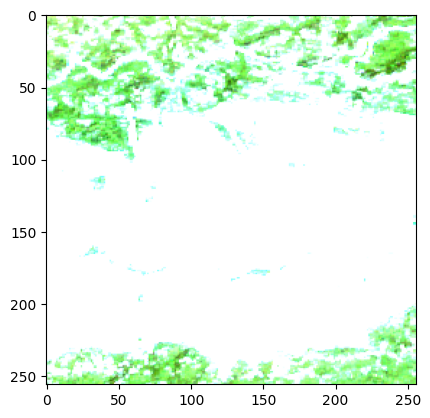

In [133]:
filename_img=input_img_paths[4]
disp_tiff(filename_img)

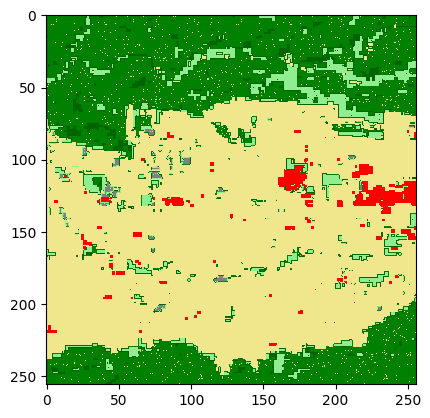

In [134]:
filename_target=target_img_paths[4]
disp_tiff(filename_target)

## Prepare sequence class to load & Vectorize batch of data

In [135]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [194]:
class ArealdData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (4,), dtype="float32") #ici le 4 !!
        for j, path in enumerate(batch_input_img_paths):
            img = load_img_tiff(path)
            x[j] = img
            
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img_tiff(path) #load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

## Perpare U-Net Xception-style model

In [195]:
from tensorflow.keras import layers
from PIL import Image
import requests

In [196]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (4,)) #ici le 4 !!

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x) 

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [197]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [198]:
# Build model
model = get_model(img_size = Img_size, num_classes = Nbr_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## U-net Architecture

In [199]:
# model design
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Set Aside a validation split

In [205]:
import random

# Split our img paths into a training and a validation set
val_samples = 10
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# Train and validation Split
train_input_img_paths = input_img_paths[:-val_samples-100]
train_target_img_paths = target_img_paths[:-val_samples-100]
val_input_img_paths = input_img_paths[-val_samples-100:-100]
val_target_img_paths = target_img_paths[-val_samples-100:-100]

# Instantiate data Sequences for each split
train_gen = ArealdData(batch_size, img_size = Img_size, input_img_paths= train_input_img_paths, target_img_paths = train_target_img_paths)
val_gen = ArealdData(10, img_size = Img_size, input_img_paths = val_input_img_paths, target_img_paths =val_target_img_paths)
     

In [201]:

# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("Arial_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
  5/577 [..............................] - ETA: 1:33:40 - loss: -2057.3789

KeyboardInterrupt: 

Visualize predictions

In [206]:
val_gen = ArealdData(batch_size, img_size = Img_size, input_img_paths=val_input_img_paths, target_img_paths= val_target_img_paths)

In [207]:
Xtest,ytest =  val_gen.__getitem__(10)
Xtest.shape, ytest.shape

((32, 256, 256, 4), (32, 256, 256, 1))

1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


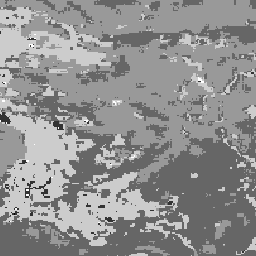

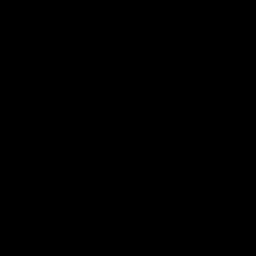

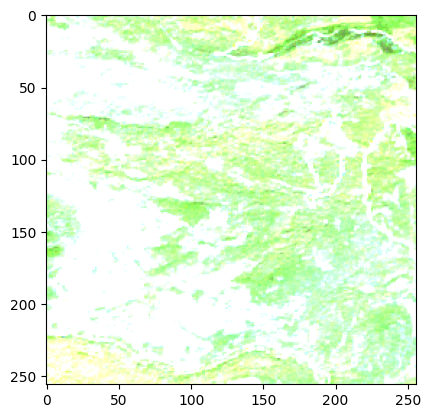

In [208]:
# Generate predictions for all images in the validation set

val_preds = model.predict(Xtest)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 1

# Display input image
disp_tiff(val_input_img_paths[i])

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.